# Predicting the Type of Angina/Chest Pain based on Age and Blood Pressure

## Introduction:
Heart disease is an extremely prevalent health issue around the world. Angina is chest pain which is experienced by individuals who fail to get enough oxygen rich blood into parts of their heart muscle. Anginas can be a sign of coronary artery disease and a warning symptom of a heart attack. Angiography is an X-ray taken of the coronary arteries which is often used to diagnose heart disease. 
 
How do age and resting blood pressure influence the type of chest pain seen in patients admitted to the university hospitals in Zurich and Basel?
 
We will be using the heart disease dataset from the Switzerland database. This dataset contains a set of 14 variables; the data was collected from 143 patients undergoing angiography in university hospitals in Zurich and Basel. Chest pain type (cp) is described by 4 values:  1 is a typical angina, 2 is an atypical angina, 3 is non-anginal pain, and 4 is asymptomatic. Trestbps represents resting blood pressure and age represents the age of the patient.


In [1]:
#import packages
library(readr)
library(tidyverse)
library(dplyr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::

In [16]:
heart_data <- read_csv('https://raw.githubusercontent.com/ftabuchi/group_21_DSCI100_project/jupyter-edits/data/processed.switzerland.data', col_names=FALSE)
heart_data |> sample_n(6)
heart_data <- heart_data |> select(X1, X3, X4)
heart_data <- heart_data |> rename(age=X1, chest_pain_ctg=X3, blood_pressure_mm_Hg=X4) |> 
                                        filter(blood_pressure_mm_Hg != "?")

knitr::kable(heart_data |> sample_n(6), caption="Heart Data")


Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
43,1,4,100,0,?,0,122,0,1.5,3,?,?,3
32,1,1,95,0,?,0,127,0,.7,1,?,?,1
63,1,4,140,0,?,2,149,0,2,1,?,?,2
67,1,1,145,0,0,2,125,0,0,2,?,3,2
35,1,4,?,0,?,0,130,1,?,?,?,7,3
52,1,4,165,0,?,0,122,1,1,1,?,7,2




Table: Heart Data

| age| chest_pain_ctg|blood_pressure_mm_Hg |
|---:|--------------:|:--------------------|
|  62|              1|140                  |
|  66|              4|155                  |
|  64|              4|110                  |
|  58|              4|115                  |
|  55|              4|120                  |
|  70|              4|140                  |

In this project, we want to predict the chest pain type with two predictors -  age and rest blood pressure. These predictors are used because these are all factors that contribute to the severity or different levels of angina. Different levels of angina through these symptoms are useful in determining cardiovascular diseases and diagnosing heart disease. Therefore, we will be using these predictors to classify the angina then make conclusions from our results.
After reading in the data by url and reading the csv, we can see that the data is fairly tidy. Now we will proceed to wrangle the data to a form that is appropriate for classification training.
.

In [1]:
set.seed(686)

#Get column 1, 3, 4, plot age vs blood pressure, colour seperated by type of chest pain

# transform and rename the 'Class' factor values to be more readable
heart_data <- heart_data |>
    mutate(blood_pressure_mm_Hg = as.numeric(blood_pressure_mm_Hg)) |>
    mutate(chest_pain_ctg = as_factor(chest_pain_ctg)) |> 
    mutate(chest_pain_ctg = fct_recode(chest_pain_ctg, "typical" = "1", "atypical" = "2", "non-anginal" = "3", "asymptomatic" = "4"))

knitr::kable(heart_data |> sample_n(6), caption = "Sample Heart Data Categorized")


ERROR: Error in mutate(mutate(mutate(heart_data, blood_pressure_mm_Hg = as.numeric(blood_pressure_mm_Hg)), : could not find function "mutate"


Looks great! Our data is now ready to be split into training and testing sets! This way we can make visualizations and determine how many neighbors provides the greatest accuracy for classifying chest pain.


In [4]:
# split our dataset into training and testing sets.
heart_split <- initial_split(heart_data, prop = 0.75, strata = chest_pain_ctg)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

glimpse(heart_train)
glimpse(heart_test)

Rows: 90
Columns: 3
$ age                  <dbl> 34, 36, 38, 38, 38, 38, 40, 41, 42, 42, 43, 46, 4…
$ chest_pain_ctg       <fct> asymptomatic, asymptomatic, asymptomatic, asympto…
$ blood_pressure_mm_Hg <dbl> 115, 110, 105, 110, 135, 150, 95, 125, 105, 145, …
Rows: 31
Columns: 3
$ age                  <dbl> 32, 38, 43, 43, 48, 50, 50, 51, 51, 51, 53, 54, 5…
$ chest_pain_ctg       <fct> typical, non-anginal, asymptomatic, asymptomatic,…
$ blood_pressure_mm_Hg <dbl> 95, 115, 100, 140, 115, 115, 120, 120, 110, 120, …


Let's create a visualization of our data with Blood Pressure on the x axis, Age on the y axis and shape-coded by chest pain type and color-coded by whether the subject has a heart disease. This visualization will allow us to see the relationship between two of our predictors, blood pressure and age. The relationship is explored further with their correlation to patients with heart disease; therefore, angina determinants and their effect on heart disease is explored. 


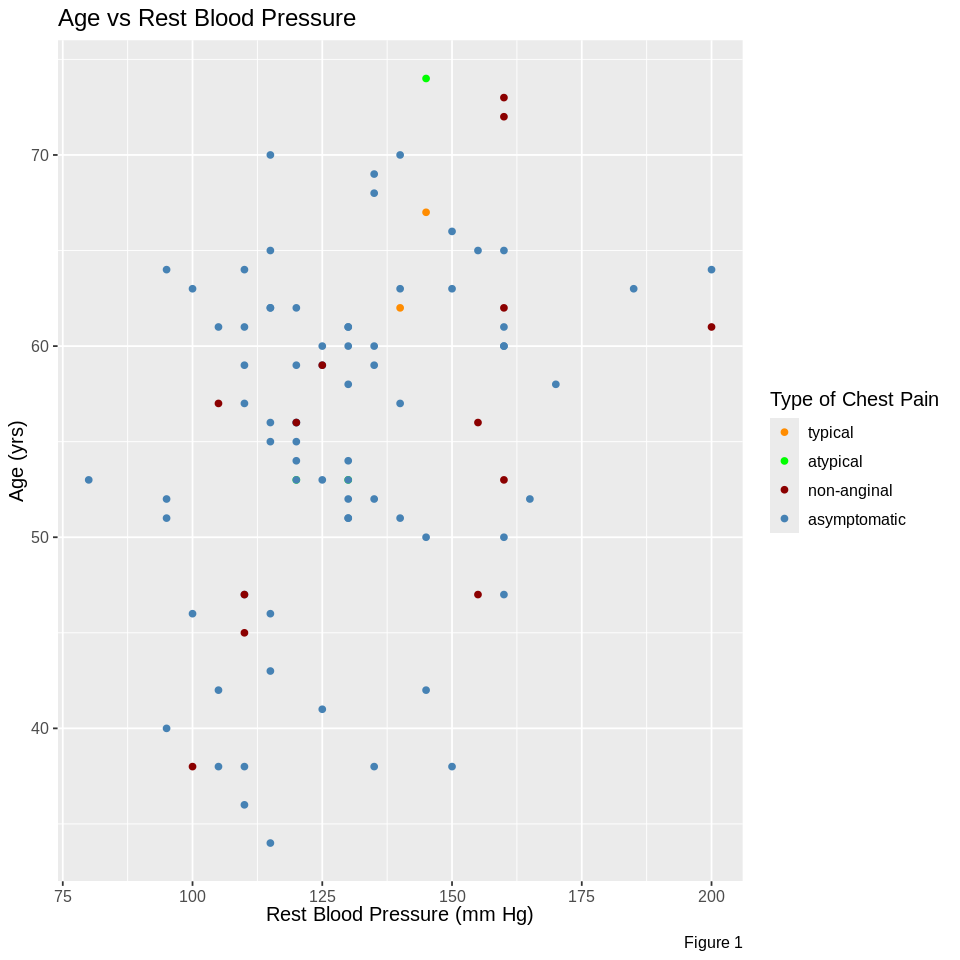

In [14]:
options(repr.plot.height = 8, repr.plot.width = 8)

# create scatter plot of heart disease training set.
heart_disease_plot <- heart_train |>
  ggplot(aes(x = blood_pressure_mm_Hg, y = age, color=chest_pain_ctg)) +
  geom_point() +
  labs(color = "Type of Chest Pain",  x="Rest Blood Pressure (mm Hg)", y="Age (yrs)", 
       caption = "Figure 1") +
  scale_color_manual(values = c("darkorange", "green", "darkred", "steelblue")) +
  theme(text = element_text(size = 12)) +
  ggtitle("Age vs Rest Blood Pressure")


heart_disease_plot

Now let's categorize the training data by the chest pain type and see the percentage of each type of angina in the data set. Then we will use the training data to determine the number of neighbors we will need based on accuracy of the predictors.

In [1]:
pain_proportions <- heart_train |>
                      group_by(chest_pain_ctg) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))
pain_proportions

ERROR: Error in mutate(summarize(group_by(heart_train, chest_pain_ctg), n = n()), : could not find function "mutate"


## Methods:
 
For this classification, we will use the predictive variables age and resting blood pressure to predict the type of chest pain seen in patients.

First we will load in the dataset, tidy it, and select for age, cp, and trestbps columns. We will split our data into training and testing sets, create a recipe, perform a cross-validation, create a K-nearest neighbors classifier, tune the model, and train the classifier with the training set via workflow. We will filter .metric for accuracy,  plot a neighbors vs. accuracy plot to visualize the best number of neighbors to set our final model. We will build a new K-nearest neighbors model with the ideal K value and run that through a workflow; this model will be used to predict the class for the test set (predict type of chest pain). 

One way we plan to visualize is to create a plot with the predictors on each axis and a different colour for each value of chest pain to visualize how the predictors can be used to predict the type of chest pain.


## Expected Outcomes and Significance:

We expect to find that as age and resting blood pressure increases, the amount of cases of chest pain will increase especially those of typical angina and asymptomatic. As  age increases cardiac complications increase because arteries become less efficient which is correlated with chest pain.

Furthremore, we expect to find the following information:
-	Most of the cases are asymptomatic.
-	Have non-anginal cases having a blood pressure near either 110 or 155.
-	Have typical cases mostly beyond the age of 60.
-	Have very rare, atypical cases, but when there is one, have them with a blood pressure around 145 and an age higher than 70.

Such findings can lead to a better categorization of the chest pain to help doctors to correctly medicate a patient even if they wrongly describe the pain. As an example, the patient could think he felt a typical chest pain, but he is 50 and has a blood pressure of 160 meaning that he is more likely to be a non-anginal type than a typical type. In this case, the medic could try to make countermeasures by re-examining the patient to make sure that he is given the correct medication.

These findings could be beneficial for better categorization of chest pain to help doctors correctly medicate a patient even if they wrongly, or cannot, describe the pain. For example, a patient could think he felt a typical angina, but due to his blood pressure and age he is predicted to have non-anginal type chest pain. In this case, the doctor could further examine the patient to make sure that he is given the correct medication. This could also lead to studies about the correlation between the pain and the treatment and studies on how to better examine the patient. Not only that, but questions about the blood pressure correlation to the pain can also appear, having studies about how medication can change the blood pressure to help alleviate the pain of the patients.

#### Future question: Is one type of chest pain more likely to be linked to diagnosed heart disease? 

##### 
And... just a little extra work to show  the accuracy of our prelimiary classifier after cross validation taking in numbers of neighbours from 2 to 6.

In [ ]:

# Create recipe
heart_recipe <- recipe(chest_pain_ctg ~ ., data = heart_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# cross-validation for best number of neighbours
heart_vfold <- vfold_cv(heart_train, v = 5, strata = chest_pain_ctg)
k_vals <- tibble(neighbors = seq(from = 2, to = 6, by = 1))

# collect metrics for each number of neighbours
knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()

# get their accuracies
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies
